<a href="https://colab.research.google.com/github/Gosox08/stroke_predictions/blob/main/stroke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.compose import make_column_transformer
from imblearn.under_sampling import NearMiss
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [53]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [54]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [55]:
df.drop(["id"], axis=1, inplace=True)

In [56]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

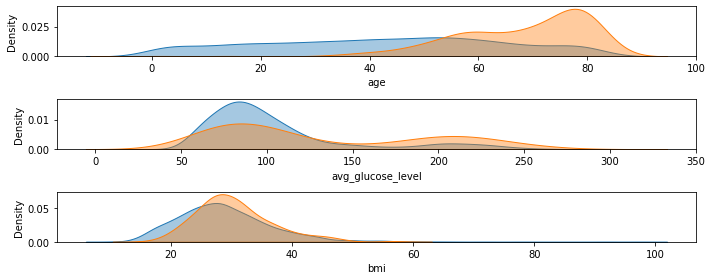

In [57]:
fig=plt.figure(figsize=(10, 4),facecolor='white')

ax=[None for i in range(3)]

plot_distribution=fig.add_gridspec(3,1)
ax[0]=fig.add_subplot(plot_distribution[0,0])
ax[1]=fig.add_subplot(plot_distribution[1,0])
ax[2]=fig.add_subplot(plot_distribution[2,0])

columns_distr = ["age", "avg_glucose_level", "bmi"]
for i, column in zip(range(3), columns_distr):
  sns.kdeplot(data = df[df["stroke"]==0], x=column, ax=ax[i], shade=True, alpha=0.4)
  sns.kdeplot(data = df[df["stroke"]==1], x=column, ax=ax[i], shade=True, alpha=0.4)
  fig.tight_layout()
  

In [58]:
df[df["gender"]=="Other"]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [59]:
df = df.drop(3116, axis=0)

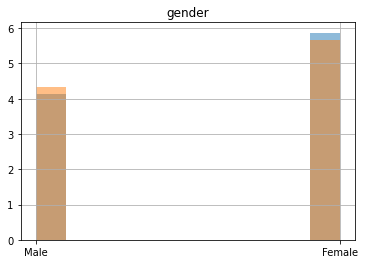

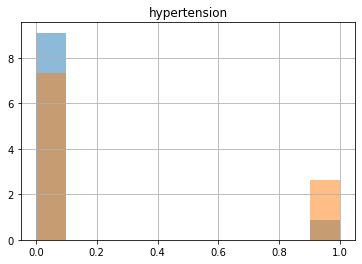

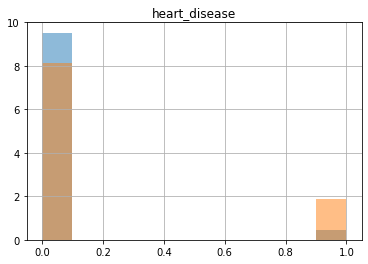

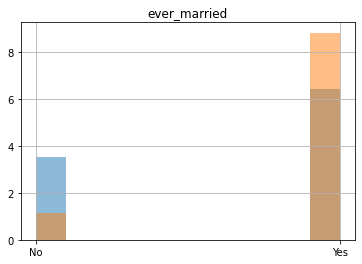

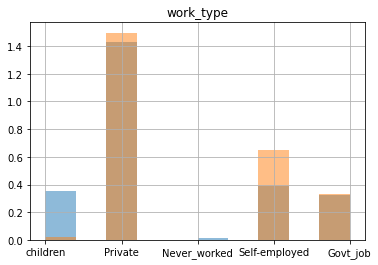

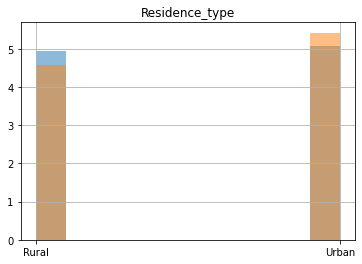

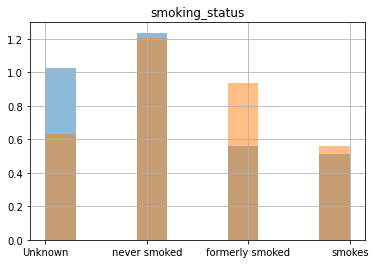

In [60]:
columns_hist = df.columns.drop(columns_distr).drop("stroke")
for column in columns_hist:
  df.groupby("stroke")[column].hist(alpha=0.5, density=True)
  plt.title(column)
  plt.show()

In [61]:
# data = df[df["gender"]=="Male"][df["stroke"]==1]
# values = {}
# explode=[]
# for key in df["smoking_status"].unique():
#   values[key]=data[data["smoking_status"]==key].shape[0]
#   explode.append(0.05)
# colors = sns.color_palette('husl', len(values))


# plt.pie(values.values(), labels=values.keys(), explode=explode, colors=colors)
# plt.show()

In [62]:
# df = df.drop(["bmi"], axis=1)
df.bmi[df['gender']=='Female'] = df.bmi[df['gender']=='Female'].fillna(df.bmi[df['gender']=='Female'].mean())
df.bmi[df['gender']=='Male'] = df.bmi[df['gender']=='Male'].fillna(df.bmi[df['gender']=='Male'].mean())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.065758,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,29.065758,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


In [64]:
ordinal_enc_dic = {}
for col_name in ['ever_married', 'Residence_type']:
  ordinal_enc_dic[col_name] = OrdinalEncoder()
  col = df[col_name]
  col_not_null = col[col.notnull()]
  reshaped_vals = col_not_null.values.reshape(-1,1)
  encoded_vals = ordinal_enc_dic[col_name].fit_transform(reshaped_vals)
  df.loc[col.notnull(), col_name] = np.squeeze(encoded_vals)

In [65]:
onehot_work = OneHotEncoder(sparse='False')
onehot_work.fit_transform(df[['work_type', 'gender', 'smoking_status']])

<5109x11 sparse matrix of type '<class 'numpy.float64'>'
	with 15327 stored elements in Compressed Sparse Row format>

In [66]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,1.0,Private,1.0,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,1.0,Self-employed,0.0,202.21,29.065758,never smoked,1
2,Male,80.0,0,1,1.0,Private,0.0,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,1.0,Private,1.0,171.23,34.400000,smokes,1
4,Female,79.0,1,0,1.0,Self-employed,0.0,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,1.0,Private,1.0,83.75,29.065758,never smoked,0
5106,Female,81.0,0,0,1.0,Self-employed,1.0,125.20,40.000000,never smoked,0
5107,Female,35.0,0,0,1.0,Self-employed,0.0,82.99,30.600000,never smoked,0
5108,Male,51.0,0,0,1.0,Private,0.0,166.29,25.600000,formerly smoked,0


In [67]:
column_trans = make_column_transformer((OneHotEncoder(), ['work_type', 'gender', 'smoking_status']), remainder='passthrough')

In [68]:
df_changed = pd.DataFrame(column_trans.fit_transform(df))
df_changed.columns= column_trans.get_feature_names()
df_columns = df_changed.columns

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [69]:
df_changed

,onehotencoder__x0_Govt_job,onehotencoder__x0_Never_worked,onehotencoder__x0_Private,onehotencoder__x0_Self-employed,onehotencoder__x0_children,onehotencoder__x1_Female,onehotencoder__x1_Male,onehotencoder__x2_Unknown,onehotencoder__x2_formerly smoked,onehotencoder__x2_never smoked,onehotencoder__x2_smokes,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,67.0,0.0,1.0,1.0,1.0,228.69,36.600000,1.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,61.0,0.0,0.0,1.0,0.0,202.21,29.065758,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,80.0,0.0,1.0,1.0,0.0,105.92,32.500000,1.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,49.0,0.0,0.0,1.0,1.0,171.23,34.400000,1.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,79.0,1.0,0.0,1.0,0.0,174.12,24.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,80.0,1.0,0.0,1.0,1.0,83.75,29.065758,0.0
5105,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,81.0,0.0,0.0,1.0,1.0,125.20,40.000000,0.0
5106,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,35.0,0.0,0.0,1.0,0.0,82.99,30.600000,0.0
5107,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,51.0,0.0,0.0,1.0,0.0,166.29,25.600000,0.0


In [70]:
X=df_changed.iloc[:, :-1]

In [71]:
y=df_changed.iloc[:, -1]

In [72]:
undersample = NearMiss(version=3, sampling_strategy=0.2)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [74]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
pca = PCA(n_components=14)
X_train_PCA = pca.fit_transform(X_train_scaled)

In [76]:
pca.explained_variance_ratio_.cumsum()

array([0.18818052, 0.30411108, 0.39956243, 0.47715392, 0.54689485,
       0.61019066, 0.66961827, 0.72609828, 0.78028839, 0.83150457,
       0.88004949, 0.92546773, 0.96354357, 0.98664362])

In [77]:
X_test_PCA = pca.transform(X_test_scaled)

In [78]:
oversample = SMOTE(sampling_strategy=0.5)
X_train_PCA, y_train = oversample.fit_resample(X_train_PCA, y_train)

In [91]:
logreg = LogisticRegression()
logreg.fit(X_train_PCA, y_train)
# X_train_PCA, X_val_PCA, y_train, y_val = train_test_split(X_train_PCA, y_train)

parameters_grid = {'C': [0.001,0.01,0.1,1,10,100,1000]}
cv=GridSearchCV(logreg, parameters_grid)

cv.fit(X_val_PCA, y_val)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [92]:
logreg = cv.best_estimator_

y_predicted = logreg.predict(X_test_PCA)

In [93]:
cv.best_params_

{'C': 100}

In [94]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91      1216
         1.0       0.18      0.63      0.28        62

    accuracy                           0.84      1278
   macro avg       0.58      0.74      0.59      1278
weighted avg       0.94      0.84      0.88      1278



In [95]:
roc_auc_score(y_test, y_predicted)

0.7400917869269948

In [101]:
from seaborn.axisgrid import Grid
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier(n_estimators=9)
rfc.fit(X_train_PCA, y_train)

parameters_grid = {
    'n_estimators': [6,7,8,9,10],
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}

cv = GridSearchCV(rfc, parameters_grid)
cv.fit(X_val_PCA, y_val)




GridSearchCV(estimator=RandomForestClassifier(n_estimators=9),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [6, 7, 8, 9, 10]})

In [102]:
rfc = cv.best_estimator_

y_predicted = rfc.predict(X_test_PCA)

In [103]:
cv.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'auto',
 'n_estimators': 10}

In [104]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      1216
         1.0       0.14      0.24      0.18        62

    accuracy                           0.89      1278
   macro avg       0.55      0.58      0.56      1278
weighted avg       0.92      0.89      0.90      1278



In [105]:
roc_auc_score(y_test, y_predicted)

0.5823164261460102